## Ilumina 450K Methylation Analysis - Basics

In [66]:
import os
import pandas as pd

meth_df = pd.read_excel('../../data/Cancer-Sample-Spreadsheets/TCGA-DATA-COMBINED.xlsx')
meth_df.head() # Pandas dataframe

,ID_REF,LUSC_tumor,LUSC_normal,COAD_tumor,COAD_normal,GBM_tumor,GBM_normal
0,cg00000029,0.312090,0.277189,0.491594,0.201456,0.862540,0.625655
1,cg00000165,0.356855,0.152366,0.867351,0.236720,0.890708,0.223732
2,cg00000236,0.914564,0.874785,0.930446,0.877313,0.908234,0.924708
3,cg00000289,0.783759,0.788907,0.765557,0.765379,0.768677,0.716382
4,cg00000292,0.854914,0.754082,0.667273,0.599161,0.565240,0.567836


In [67]:
content = []
eul1db_srip_list = []
with open("../../data/eul1db-data/eul1db_srip.bed")as f:
    for line in f:
        content.append(line.strip().split())
for i, line in enumerate(content):
    if i < 3:
        continue
    eul1db_srip_list.append([line[0][3:], line[1], line[2], line[5]])
headers = ['Chr','Start','End','Strand']
eul1db_srip_df = pd.DataFrame(eul1db_srip_list, columns=headers)
eul1db_srip_df.head(n=5)

,Chr,Start,End,Strand
0,1,815511,815511,-
1,1,980069,980069,+
2,1,1149273,1149273,-
3,1,1687509,1687509,-
4,1,3053277,3053277,-


In [68]:
l1base_df = pd.read_excel('../../data/l1base/l1base.xlsx')
l1base_list = []

for index, row in l1base_df.iterrows():
    l1base_list.append([row[0], row[1], row[2], row[5]])

l1base_df = pd.DataFrame(l1base_list, columns=headers)
l1base_df.head(5)

,Chr,Start,End,Strand
0,8,134077776,134069730,-1
1,8,128460023,128451975,-1
2,8,72882593,72874543,-1
3,8,72154468,72146429,-1
4,8,91557655,91565704,1


In [69]:
class Probe:
    """
    Holds Illumina 450k probe info for a single CpG site.
    """
    def __init__(self):
        self.id = None
        self. seq = None
        self.name = None
        self.chr = None
        self.cord = None
        self.strand = None
        self.gene = None
        self.refseq = None
        self.tour = None
        self.loc = None
        
class Interval:
    """
    Define a genomic interval by chromsome and strand orientation.
    """
    def __init__(self, chromosome, start, end, strand):
        self.chr = chromosome
        self.start = start
        self.end = end
        self.strand = strand

class Location:
    """
    Define a Probe location.
    """
    BODY = "Body"
    TSS200 = "TSS200"
    TSS1500 = "TSS1500"
    UTR5 = "5'UTR"
    UTR3 = "3'UTR"
    EXON = "Exon"

class CpG_location:
    """
    Defines a CpG location.
    """
    ISLAND = "Island"
    NSHORE = "N_Shore"
    SSHORE = "S_Shore"
    NSHELF = "N_Shelf"
    SSHELF = "S_Shelf"
    
class SNP:
    """
    Defines the SNPs in probes. Used to filter probes.
    """

    def __init__(self):
        self.probeid = None
        self.snpid = None

In [70]:
import os

anno_file = os.path.abspath("../../data/config.ini") # Illumina probe manifest. Note: This (large) file is not 
                                                     # in the repository.
    
class Annotate_450k:
    """
    Parse and hold information about Illumina probes.
    """

    def __init__(self):        
        for i in open(anno_file, mode="r"):
            self.ann = os.path.join("../../data/", i.strip("\n").strip("\r"))

        self.probe = {}
        self.__run__()

    def __run__(self):
        """
        A static function to setup the Probe classes.
        """
        for i in open(self.ann, mode="r"):
            if i.startswith("cg"):
                data = i.split(",")
                # Assign probe information.
                new_probe = Probe()
                new_probe.id = data[0]
                new_probe.name = data[1]
                new_probe.seq = data[13]
                new_probe.chr = str(data[11])
                new_probe.cord = int(data[12])
                new_probe.strand = data[16]
                new_probe.gene = data[21].split(";")
                new_probe.refseq = data[22]
                locs = data[23].split(";")
                list_locs = []
                for i in locs:
                    if i not in list_locs:
                        list_locs.append(i)

                new_probe.loc = list_locs

                new_probe.tour = data[25]
                newcpg = {new_probe.id: new_probe}
                self.probe.update(newcpg)

    def get_probe(self, probe_id): #WORKS
        """
        Return probe info associated with an reference.
        """
        try:
            probe = self.probe[probe_id]
        except Exception as ex:
            probe = None
            print("WARNING: No probe with ref-id of %s found." % probe_id)
        return probe

    def get_all_probes(self):
        """
        Return list of all probes.
        """
        probe_list = []
        for probe in self.probe.keys():
            probe_list.append(self.get_probe(probe))
        return probe_list
    
    def get_probes_by_list(self, list_of_ids):
        """
        Return a list of probes from a list of references.
        """
        out_list = []
        for probe_id in list_of_ids:
            out_list.append(self.get_probe(probe_id))

        return out_list
    
    def get_probe_refs_by_gene(self, gene_name):
        """
        Get all probe references associated with a gene.
        """
        probes = {k: self.probe[k] for k in self.probe if gene_name in self.probe[k].gene}
        return self.get_keys(probes.keys())

    def get_probe_refs_by_location(self, probe_loc):
        """
        Get all probe references associated with a genomic location.
        """
        probes = {k: self.probe[k] for k in self.probe if probe_loc in self.probe[k].loc}
        return self.get_keys(probes.keys())

    def get_keys(self, dic_keys):
        """
        Get Probe reference from probe dictionaries.
        """
        l = []
        for i in dic_keys:
            l.append(i)
        return l

    def get_probes_by_gene(self, gene_name):
        """
        Return list of probes for an associated gene.
        """
        return self.get_probes_by_list(self.get_probe_refs_by_gene(gene_name))

    def get_probes_by_location(self, loc):
        """
        Return list of probes from genomic location.
        """
        return self.get_probes_by_list(self.get_probe_refs_by_location(loc))

    def get_probes_by_cpg(self, cpg_loc):
        """
        Get a list probes from cpg location.
        FIXME
        """
        return self.get_probes_by_list(self.get_probes_by_cpg(cpg_loc))

    def get_probes_by_chr(self, chr_loc):
        """
        Get a list of probes within a certain genomic region
        FIXME
        """
        print (chr_loc.chr)
        probes = {k: self.probe[k] for k in self.probe if
                  self.probe[k].chr == chr_loc.chr}

    def get_probes_by_chr_and_loc(self, chr_loc):
        """
        Get a list of probes within a certain genomic region
        FIXME
        """
        chrom = chr_loc.chr
        start = int(chr_loc.start)
        end = int(chr_loc.end)
        
        #print (chrom, start, stop)

        probes = {k: self.probe[k] for k in self.probe if
                  self.probe[k].chr == chrom and start < self.probe[k].cord < end}
        return probes

    def get_probe_keys_by_chr_and_loc(self, chr_loc):
        """
        Get a list of probe reference *keys* within a genomic region
        FIXME
        """
        probes = self.get_probes_by_chr_and_loc(chr_loc)
        return self.get_keys(probes)

    def get_number(self):
        """
        Return total number of probes.
        """
        number = 0
        for probe_id in self.probe.keys():
            number += 1

        return number

    def get_coord(self, probe):
        """
        Get genomic coordinate of a single probe.
        """
        return probe.cord
    
    def get_sorted_probes_by_id(self):
        """
        Sort probes according to probe id.
        """
        sorted_keys = sorted(list(self.probe.keys()))
        return sorted_keys
    
    def get_sorted_probes_by_chr(self):
        """
        Sort probes according to probe id.
        """
        return sorted(self.get_all_probes(), key=lambda x: x.chr)
    
    def remove_snp_probes(self):
        """
        Removes all SNPs associated with probes.
        """
        snp_list = []
        snp_file = open("../../data/humanmethylation450_dbsnp137.snpupdate.table.v2.sorted.txt", "r")
        for line in snp_file:
            if line.startswith("cg"):
                line = line.strip("\n").strip("\r").split("\t")
                new_snp = SNP()
                new_snp.probeid = line[0]
                new_snp.snpid = line[1]
                snp_list.append(new_snp)

        for snp in snp_list:
            self.probe.pop(snp.probeid)

In [71]:
annotate = Annotate_450k() # create annotation object containing *all* 450k probes 
annotate.get_number()

482421

In [81]:
cg00050873 = annotate.probe['cg00050873']
cg00050873.cord

9363356

In [58]:
annotate.remove_snp_probes()
all_probes = annotate.get_all_probes()
annotate.get_number()

210294

In [59]:
sorted_keys = annotate.get_sorted_probes_by_id()
sorted_keys[0], sorted_keys[210293]

('cg00000029', 'cg27666046')

In [60]:
cg00000029 = annotate.get_probe(sorted_keys[0])
cg27666046 = annotate.get_probe(sorted_keys[210293])

In [61]:
cg00000029.cord, cg27666046.cord, cg00000029.tour

(53468112, 80279077, 'N_Shore')

In [51]:
probe_list = annotate.get_probes_by_list(sorted_keys[0:5]) # get first 5 probes
for probe in probe_list: # sorting on probe id does not follow by chr in an expected way. 
    print ('ID: {p}, Chr: {c}'.format(p=probe.id, c=probe.chr)) 

NameError: name 'annotate' is not defined

In [16]:
sorted_by_chr = annotate.get_sorted_probes_by_chr()
chromosome1 = sorted_by_chr[0:46566] # huh?
chromosome1[0].cord, chromosome1[46565].cord

(91194674, 220863462)

In [44]:
# Return probes in the vicinity of a gene
probe_refs = annotate.get_probe_refs_by_gene('SRPK1')
probe_refs[0]

'cg08603125'

In [46]:
# Return probes in vicinity of a gene (i.e. SRPK1)
probes_from_gene = annotate.get_probes_by_gene('SRPK1')
print ('SRPK1 probe found on Chr {p}.'.format(p=probes_from_gene[0].chr))

SRPK1 probe found on Chr 6.


In [47]:
# Return probes in vicinity of a feature (i.e. BODY, TSS200, TSS1500, UTR5, UTR3)
BODY_probes = annotate.get_probes_by_location(Location.BODY) # 
TSS200_probes = annotate.get_probes_by_location(Location.TSS200) #
TSS1500_probes = annotate.get_probes_by_location(Location.TSS1500) #
UTR3_probes = annotate.get_probes_by_location(Location.UTR3) #
UTR5_probes = annotate.get_probes_by_location(Location.UTR5) #

In [48]:
print (len(BODY_probes), len(TSS1500_probes), len(UTR5_probes), len(TSS200_probes), len(UTR3_probes))

67322 42499 33318 32853 8011


In [22]:
df_short = meth_df.head(5) # short list, for testing 
methyl_probe_dict = {}

for index, row in df_short.iterrows():
    methyl_probe_dict[row[0]] = annotate.probe.get(row[0]) # row[0] == 'cg00000029' i.e. key value
    setattr(methyl_probe_dict[row[0]], 'LUSC_tumor_beta',  row[1]) # add spreadsheet attributes 
    setattr(methyl_probe_dict[row[0]], 'LUSC_normal_beta', row[2]) # from TCGA-DATA-COMBINED.xlsx...
    setattr(methyl_probe_dict[row[0]], 'COAD_tumor_beta',  row[3])
    setattr(methyl_probe_dict[row[0]], 'COAD_normal_beta', row[4])
    setattr(methyl_probe_dict[row[0]], 'GBM_tumor_beta',   row[5])
    setattr(methyl_probe_dict[row[0]], 'GBM_normal_beta',  row[6])

In [23]:
cg00000292 = methyl_probe_dict['cg00000292'] # get a 'methyl' probe by name

In [24]:
[a for a in dir(cg00000292) if not a.startswith('__')] # list attributes of a single probe, including our data

['COAD_normal_beta',
 'COAD_tumor_beta',
 'GBM_normal_beta',
 'GBM_tumor_beta',
 'LUSC_normal_beta',
 'LUSC_tumor_beta',
 'chr',
 'cord',
 'gene',
 'id',
 'loc',
 'name',
 'refseq',
 'seq',
 'strand',
 'tour']

In [25]:
cg00000292.cord, cg00000292.refseq, cg00000292.COAD_tumor_beta, cg00000292.COAD_normal_beta

(28890100, 'NM_004320;NM_173201', 0.667273112085446, 0.599161178855325)

In [ ]:
srips_start = eul1db_srip_df['Start'] # get the SRIP series as a list of locations. 
for val in srips_start.tolist():
    

In [26]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(4, 3))
meth_df.boxplot(column=['GBM_tumor', 'GBM_normal'])

# Boxplot of the difference
plt.figure(figsize=(4, 3))
plt.boxplot(meth_df['GBM_normal'] - meth_df['GBM_tumor'])
plt.xticks((1, ), ('GBM_normal - GBM_tumor', ))

plt.show()

<Figure size 400x300 with 1 Axes>

<Figure size 400x300 with 1 Axes>

The three paired box plots are to test (the dataset is small) however the expected trend is observed: in GBM glioblastoma (above) there is no difference in methylation of CpGs in tumor compared to normal tissue.

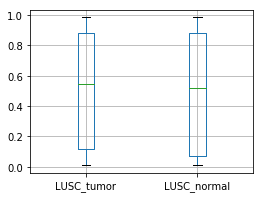

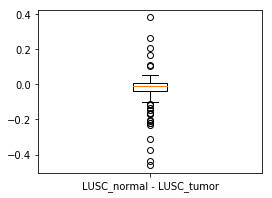

In [27]:
import matplotlib.pyplot as plt

# Box plot of LUSC_tumor and LUSC_normal
plt.figure(figsize=(4, 3))
meth_df.boxplot(column=['LUSC_tumor', 'LUSC_normal'])

# Boxplot of the difference
plt.figure(figsize=(4, 3))
plt.boxplot(meth_df['LUSC_normal'] - meth_df['LUSC_tumor'])
plt.xticks((1, ), ('LUSC_normal - LUSC_tumor', ))

plt.show()

In lung squamous cell carcinoma (above) there is only a nominal rise.

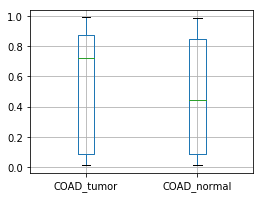

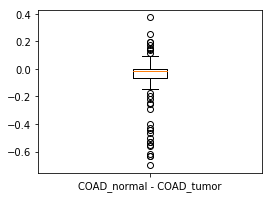

In [206]:
plt.close('all')

plt.figure(figsize=(4, 3))
meth_df.boxplot(column=['COAD_tumor', 'COAD_normal'])

# Boxplot of the difference
plt.figure(figsize=(4, 3))
plt.boxplot(meth_df['COAD_normal'] - meth_df['COAD_tumor'])
plt.xticks((1, ), ('COAD_normal - COAD_tumor', ))

plt.show()

In colorectal cancers 600-800 genes are transcriptionally-silenced by CpG island methylation compared to normal tissue. Transcriptional silencing may be more important than mutation in causing gene silencing in progression to cancer.

About 70% of human promoters located near the transcription start site of a gene contain a CpG island.

In [ ]:
# Try subclassing...

class LUSCProbe (Probe):
    def __init__ (self):
        super().__init__()
        self.LUSC_tumor = None
        #print('LUSC_tumor')

class GBMProbe (Probe):
    def __init__ (self):
        super().__init__()
        self.GBM_tumor = None
        #print('GBM_tumor')

class COADProbe (Probe):
    def __init__ (self):
        super().__init__()
        self.COAD_tumor = None
        #print('COAD_tumor')
        
class BunchDict(dict):
    def __init__(self,**kw):
        dict.__init__(self,kw)
        self.__dict__.update(kw)

```pre
4 	169522534 	169514488 	-1
4 	136300550 	136292503 	-1
4 	93645340 	93637294 	-1
4 	90682759 	90674713 	-1
4 	74724589 	74716542 	-1
4 	21158389 	21166435 	1
4 	59077843 	59085891 	1
4 	78346978 	78355029 	1

6 	156360250 	156368290 	1
6 	133027748 	133019702 	-1
6 	72995688 	72987641 	-1
6 	24818709 	24810663 	-1
6 	2424805 	2416758 	-1

11 	24326949 	24334995 	1
11 	60531157 	60539204 	1
11 	93135637 	93143687 	1
11 	93419971 	93428022 	1
11 	95435214 	95443260 	1
11 	109184528 	109176481 	-1
11 	90407101 	90399050 	-1
11 	78684806 	78676759 	-1

16 	63387072 	63395120 	1
16 	83636249 	83644311 	1
16 	33959614 	33951564 	-1
16 	21049705 	21041661 	-1
16 	18828286 	18820240 	-1
16 	16847570 	16839523 	-1
16 	9591524 	9583477 	-1

15 	54933102 	54925054 	-1
15 	70728652 	70736174 	1
15 	71173133 	71181170 	1
15 	87508887 	87516934 	1
15 	93674398 	93682446 	1
```